# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Компания по продаже б/у автомобилей разрабатывает новую функцию своего приложения. В нём можно автоматически определить рыночную стоимость своего автомобиля.

Задачи:
1) Загрузить и подготовить данные.
2) Обучить разные модели.
3) Проанализировать скорость работы и качество моделей.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

In [2]:
data = pd.read_csv('C:/Users/user/Downloads/auto.csv')
display(data.head())
display(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [3]:
print("Кол-во дубликатов:",data.duplicated().sum())
print(data.isna().sum())
data.describe()

Кол-во дубликатов: 4
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1. Есть дубликаты, пропуски, аномальные значения(например в столбце power,RegistrationYear)
2. Признаки NumberOfPictures,PostalCode,RegistrationMonth не несут полезной информации и будут лишними для модели. 

Избавимся от пропусков и ненужных признаков.

In [4]:
data = data.drop_duplicates()
data = data.drop(['NumberOfPictures','PostalCode','RegistrationMonth','DateCrawled'],axis=1)

Займемся пропусками и аномальными значениями.
Построим матрицу графиков рассеяния.

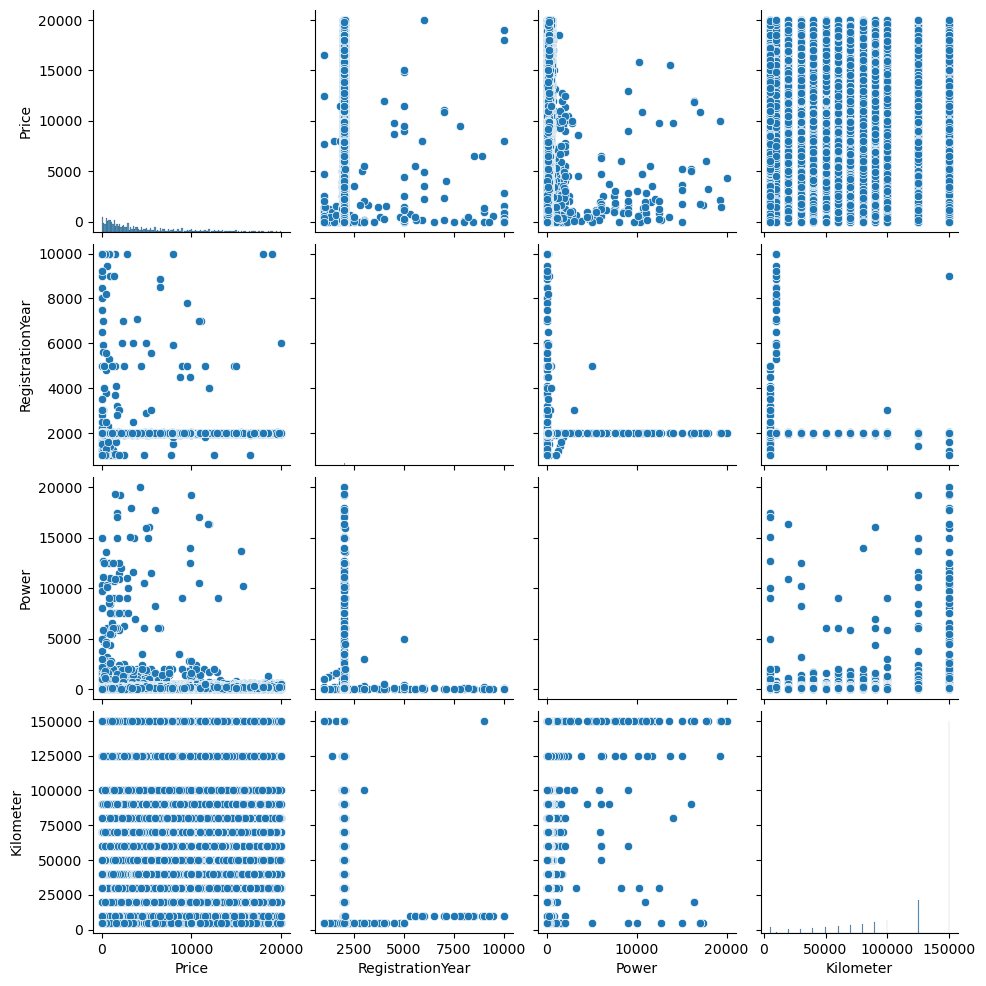

In [5]:
sns.pairplot(data)

In [6]:
display(data.isna().sum())

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
DateCreated             0
LastSeen                0
dtype: int64

In [7]:
data = data.query('Price > 0')
data = data.query('1960 < RegistrationYear <= 2023')

In [8]:
data.loc[(data['Power'] > 1000) | (data['Power'] <= 0), 'Power'] = None
data['Power'] = data['Power'].fillna(data.groupby('Model')['Power'].transform('median'))
data = data.query('Power.notnull()')

<Axes: xlabel='Power', ylabel='Count'>

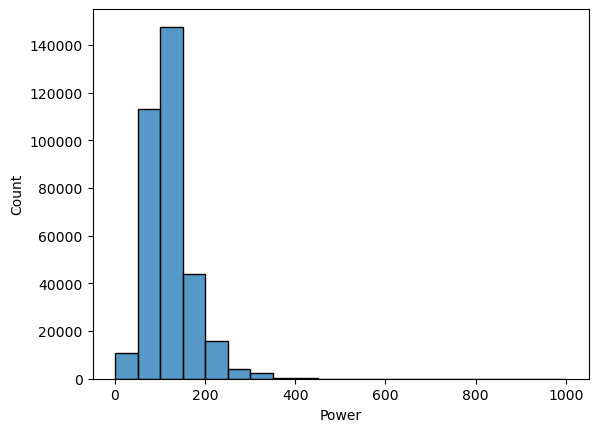

In [9]:
sns.histplot(data['Power'], bins=20)

Признак Model восстановить никак не получится.

VehicleType, Gearbox, FuelType - пропуски в этих признаках заполним наиболее типичными значениями по модели автомобиля.

Пропуски признака Repaired заменим на 'unknown'.

In [10]:
data = data.query("Model.notnull()")
data['VehicleType'] = data.groupby('Model')['VehicleType'].transform(lambda x:x.fillna(x.mode()[0]))
data['Gearbox'] = data.groupby('Model')['Gearbox'].transform(lambda x:x.fillna(x.mode()[0]))
data['FuelType'] = data.groupby('Model')['FuelType'].transform(lambda x:x.fillna(x.mode()[0]))
data['Repaired'] = data['Repaired'].fillna('unknown')

Надо преобразовать типы данных. Признаки DateCreated и LastSeen скорее всего тоже будут лишними. 

In [11]:
data = data.drop(['DateCreated','LastSeen'],axis=1)

In [12]:
data['Power'] = data['Power'].round()
data['Power'] = pd.to_numeric(data['Power'], downcast='integer')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325738 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             325738 non-null  int64 
 1   VehicleType       325738 non-null  object
 2   RegistrationYear  325738 non-null  int64 
 3   Gearbox           325738 non-null  object
 4   Power             325738 non-null  int16 
 5   Model             325738 non-null  object
 6   Kilometer         325738 non-null  int64 
 7   FuelType          325738 non-null  object
 8   Brand             325738 non-null  object
 9   Repaired          325738 non-null  object
dtypes: int16(1), int64(3), object(6)
memory usage: 25.5+ MB


Выводы:
Данные загружены и изучены.
Аномальные значения удалены, пропущенные заполнены.
Отобраны необходимые признаки для обучения модели.

## Обучение моделей

In [14]:
features = data.drop(['Price'], axis=1)
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.2,random_state=12345)

In [15]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

In [16]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)
ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['RegistrationYear', 'Power', 'Kilometer']
['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [17]:
encoder = OrdinalEncoder()
encoder.fit(features_train[ohe_features_ridge])
features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[ohe_features_ridge] = encoder.transform(features_train_ord[ohe_features_ridge])
features_test_ord[ohe_features_ridge] = encoder.transform(features_test_ord[ohe_features_ridge])

Удаляем лишние признаки

In [18]:
train_cols = set(features_train_ohe.columns)
test_cols = set(features_test_ohe.columns)
extra_cols = train_cols - test_cols

In [19]:
extra_cols

{'Model_range_rover_evoque', 'Model_rangerover', 'Model_serie_3'}

In [20]:
features_train_ohe = features_train_ohe.drop(columns=extra_cols)
#features_test_ohe = features_test_ohe.drop(columns=extra_cols)

In [21]:
train_cols = set(features_train_ohe.columns)
test_cols = set(features_test_ohe.columns)
extra_cols = train_cols - test_cols

Рассчитаем rmse для константной модели.

In [22]:
constant = np.full_like(target,target.mean())
rmse = np.sqrt(mean_squared_error(target, constant))
print(rmse)

4528.590220791851


# 2.1 Линейная регрессия.

In [23]:
%%time
model = LinearRegression()
print('# Train for root_mean_squared_error')
print()
rmse_lr = (cross_val_score(model, 
                             features_train_ohe, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE =', rmse_lr)

# Train for root_mean_squared_error

Mean RMSE = 2704.471821280641
CPU times: total: 1min 12s
Wall time: 36.5 s


In [24]:
%%time

model.fit(features_train_ohe, target_train)

CPU times: total: 18.6 s
Wall time: 7.51 s


LinearRegression()

# 2.2 DecisionTreeRegressor

In [25]:
%%time
model = DecisionTreeRegressor()
max_depth_list = [x for x in range(2, 15)]
hyperparams = [{'criterion':['squared_error'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ord, target_train)
print("Наилучшие параметры:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']

RMSE = (max(means)*-1) ** 0.5
print(RMSE)

Наилучшие параметры:

{'criterion': 'squared_error', 'max_depth': 14, 'random_state': 12345}

Grid scores on development set:

1919.2907367959992
CPU times: total: 24.6 s
Wall time: 26.4 s


In [26]:
fit_time = clf.cv_results_['mean_fit_time']
fit_time.mean()

0.3824452803685115

# 2.3 Регрессия LGBMRegressor

In [27]:
%%time
model = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]
clf = GridSearchCV(model, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train)
print("Наилучшие параметры:")
print(clf.best_params_)
print()
means = clf.cv_results_['mean_test_score']

RMSE = (max(means)*-1) ** 0.5

Наилучшие параметры:
{'learning_rate': 0.3, 'num_leaves': 200, 'random_state': 12345}

CPU times: total: 6min 2s
Wall time: 3min 4s


In [28]:
print(RMSE)

1587.007102626928


In [29]:
fit_time_lgbmr = clf.cv_results_['mean_fit_time']
fit_time.mean()

0.3824452803685115

## Анализ моделей

Все модели улучшили показатели RMSE константной модели.

**Линейная регрессия:

- Mean RMSE = 2704.359312312232
- Wall time: 36.5 s


**DecisionTreeRegressor:

- RMSE = 1919.9795844951286
- Wall time: 26.4 s


**LGBMRegressor:

- RMSE = 1587.007102626928
- время обучения: Wall time: 3min 4s
- время предикта: Wall time: 681 ms


Время обучения у линейной регрессии самое низкое, но метрика RMSE почти в два раза больше чем у LightGBM.
DecisionTreeRegressor обучался дольше всех моделей, по качеству уступает LGBMRegressor.


## Тестирование лучшей модели

Рекомендуемая модель LGBMRegressor

In [30]:
%%time

model = LGBMRegressor(learning_rate=0.3, 
                      num_leaves=200, 
                      random_state=12345)

model.fit(features_train_ohe, target_train)

CPU times: total: 8.95 s
Wall time: 3.86 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [31]:
%%time
target_predict = model.predict(features_test_ohe)
test_RMSE = mean_squared_error(target_test, target_predict) ** 0.5
print(test_RMSE)

1549.2267257015526
CPU times: total: 1.58 s
Wall time: 681 ms


Вывод:
Данные загружены и обработаны. Исследовано несколько моделей с использованием различных гиперпараметров. Выбрана лучшая модель.

Наилучшей моделью оказалась LGBMRegressor.